# Importação de Bibliotecas
Nesta etapa, importamos as bibliotecas necessárias para manipulação de dados, treinamento do modelo e avaliação.

In [73]:
import pandas as pd
import joblib
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [74]:
df = pd.read_csv("gpu_data.csv")
print(df.columns)
df['gpu_peak'] = (df['gpu_utilization (%)'] > 80).astype(int)

Index(['timestamp', 'gpu_utilization (%)', 'memory_utilization (%)',
       'gpu_power_draw (W)', 'gpu_temperature (°C)', 'gpu_fan_speed (%)',
       'gpu_clock_speed (MHz)', 'cpu_utilization (%)', 'memory_usage (%)',
       'server_power_draw (W)', 'server_temperature (°C)', 'disk_usage (%)',
       'network_bandwidth (Mbps)'],
      dtype='object')


In [75]:
features = [
    'gpu_utilization (%)',
    'memory_utilization (%)',
    'gpu_power_draw (W)',
    'gpu_temperature (°C)',
    'gpu_fan_speed (%)',
    'gpu_clock_speed (MHz)',
    'cpu_utilization (%)',
    'memory_usage (%)',
    'server_power_draw (W)',
    'server_temperature (°C)',
    'disk_usage (%)',
    'network_bandwidth (Mbps)'
]
X = df[features]
y = df['gpu_peak']

print(f"Feature shape: {X.shape}")
print(f"Number of features: {X.shape[1]}")

Feature shape: (2017, 12)
Number of features: 12


In [76]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [77]:
y_pred = rf_model.predict(X_test)
print(classification_report(y_test, y_pred))

feature_importances = pd.DataFrame({
    'Feature': features,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)
print(feature_importances)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       328
           1       1.00      1.00      1.00        76

    accuracy                           1.00       404
   macro avg       1.00      1.00      1.00       404
weighted avg       1.00      1.00      1.00       404

                     Feature  Importance
0        gpu_utilization (%)    0.909159
4          gpu_fan_speed (%)    0.011555
7           memory_usage (%)    0.011110
6        cpu_utilization (%)    0.009636
1     memory_utilization (%)    0.008460
8      server_power_draw (W)    0.008031
10            disk_usage (%)    0.007969
11  network_bandwidth (Mbps)    0.007478
5      gpu_clock_speed (MHz)    0.007377
9    server_temperature (°C)    0.006765
2         gpu_power_draw (W)    0.006710
3       gpu_temperature (°C)    0.005750


In [78]:
# Test prediction with sample data to ensure correct format
sample_data = X_test.iloc[0:1]
print("Sample prediction input shape:", sample_data.shape)
print("Sample prediction result:", rf_model.predict(sample_data)[0])

model_data = {
    'model': rf_model,
    'feature_names': features
}
joblib.dump(model_data, "modelo.pkl")
print("Model saved with feature names")

Sample prediction input shape: (1, 12)
Sample prediction result: 0
Model saved with feature names


In [79]:
df_ts = df[['timestamp', 'gpu_utilization (%)']].copy()
df_ts['timestamp'] = pd.to_datetime(df_ts['timestamp'])
df_ts = df_ts.set_index('timestamp')

df_ts = df_ts.asfreq('h')

df_ts = df_ts.dropna()

print(df_ts.head())

                            gpu_utilization (%)
timestamp                                      
2025-03-19 22:04:59.495312                88.54
2025-03-19 23:04:59.495312                45.31
2025-03-20 00:04:59.495312                74.03
2025-03-20 01:04:59.495312                38.10
2025-03-20 02:04:59.495312                34.62


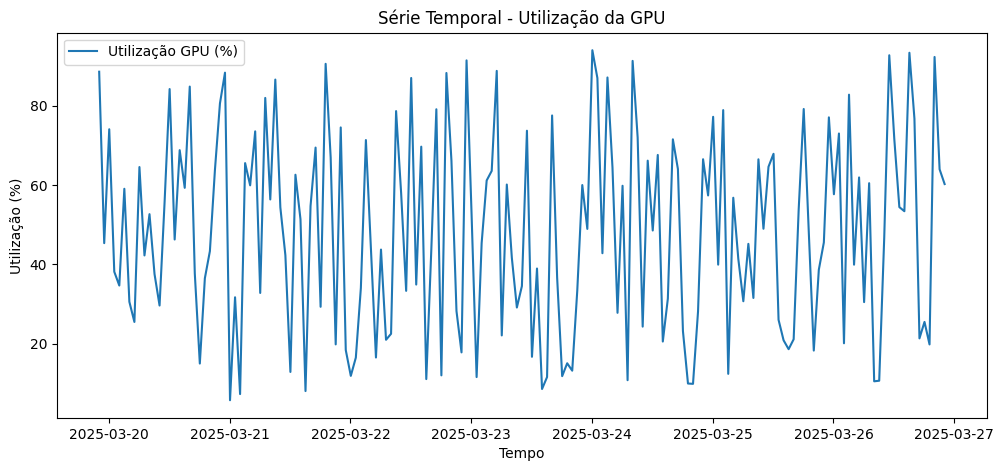

In [80]:
# Plota a série temporal da utilização da GPU
plt.figure(figsize=(12, 5))
plt.plot(df_ts.index, df_ts['gpu_utilization (%)'], label='Utilização GPU (%)')
plt.title('Série Temporal - Utilização da GPU')
plt.xlabel('Tempo')
plt.ylabel('Utilização (%)')
plt.legend()
plt.show()

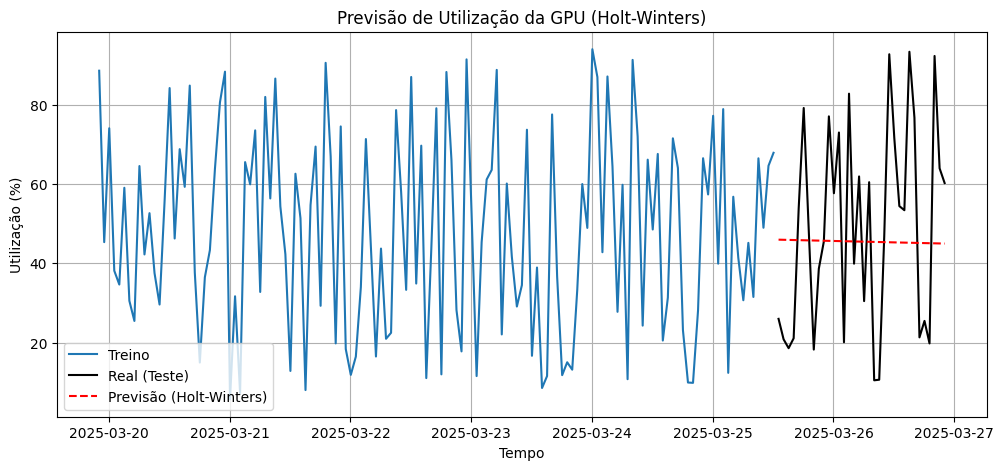

In [81]:
train_size = int(len(df_ts) * 0.8)
train, test = df_ts.iloc[:train_size], df_ts.iloc[train_size:]

hw_model = ExponentialSmoothing(train['gpu_utilization (%)'], trend='add', seasonal=None).fit()

forecast = hw_model.forecast(steps=len(test))

plt.figure(figsize=(12, 5))
plt.plot(train.index, train['gpu_utilization (%)'], label='Treino')
plt.plot(test.index, test['gpu_utilization (%)'], label='Real (Teste)', color='black')
plt.plot(test.index, forecast, label='Previsão (Holt-Winters)', color='red', linestyle='dashed')
plt.title('Previsão de Utilização da GPU (Holt-Winters)')
plt.xlabel('Tempo')
plt.ylabel('Utilização (%)')
plt.legend()
plt.grid(True)
plt.show()

In [82]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(test['gpu_utilization (%)'], forecast)
print(f"Erro Quadrático Médio (MSE): {mse:.2f}")

Erro Quadrático Médio (MSE): 655.62


In [83]:
novo_dado = X_test.iloc[0] 

from sklearn.ensemble import RandomForestClassifier


previsao_pico = rf_model.predict(novo_dado.values.reshape(1, -1))[0]

if previsao_pico == 1:
    print("Previsão: Pico de utilização da GPU detectado!")
else:
    print("Previsão: Sem pico de utilização da GPU.")

Previsão: Sem pico de utilização da GPU.


C:\Users\Lopes\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [84]:
print("Distribuição de GPU Peak:")
print(y.value_counts(normalize=True))

Distribuição de GPU Peak:
gpu_peak
0    0.825483
1    0.174517
Name: proportion, dtype: float64


In [85]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    "n_estimators": [50, 100, 200],
    "max_depth": [None, 10, 20],
    "class_weight": ["balanced"]
}

grid = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    cv=3,
    scoring="f1",
    n_jobs=-1
)
grid.fit(X_train, y_train)

best_rf = grid.best_estimator_
print("Melhores parâmetros:", grid.best_params_)

Melhores parâmetros: {'class_weight': 'balanced', 'max_depth': None, 'n_estimators': 50}


In [86]:
y_pred_best = best_rf.predict(X_test)
print("Relatório de classificação (melhor RF):")
print(classification_report(y_test, y_pred_best))

Relatório de classificação (melhor RF):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       328
           1       1.00      1.00      1.00        76

    accuracy                           1.00       404
   macro avg       1.00      1.00      1.00       404
weighted avg       1.00      1.00      1.00       404



In [87]:
model_data = {
    "model": best_rf,
    "feature_names": features
}
joblib.dump(model_data, "modelo.pkl")
print("Modelo otimizado salvo em 'modelo.pkl'")

Modelo otimizado salvo em 'modelo.pkl'


# Visualização de Previsões de Pico

Neste gráfico, destacamos em vermelho os timestamps em que o RandomForest prevê pico de utilização.

In [88]:
# Monta DataFrame de teste com previsões
test_df = test.to_frame(name='gpu_utilization (%)')
test_df['pred_peak'] = best_rf.predict(test_df[features])

# Plot da série temporal com picos previstos
plt.figure(figsize=(12,5))
plt.plot(test_df.index, test_df['gpu_utilization (%)'], label='Utilização GPU')
plt.scatter(
    test_df.index[test_df['pred_peak']==1],
    test_df['gpu_utilization (%)'][test_df['pred_peak']==1],
    color='red', label='Pico Previsto'
)
plt.title('Utilização da GPU e Picos Previsto pelo RandomForest')
plt.xlabel('Tempo')
plt.ylabel('Utilização (%)')
plt.legend()
plt.grid(True)
plt.show()

AttributeError: 'DataFrame' object has no attribute 'to_frame'